In [1]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [2]:
# Benchmark functions
def ackley(xx, a=20, b=0.2, c=2*np.pi):
    d = len(xx)
    sum1 = np.sum(np.square(xx))
    sum2 = np.sum(np.cos(c * np.array(xx)))
    term1 = -a * np.exp(-b * np.sqrt(sum1 / d))
    term2 = -np.exp(sum2 / d)
    y = term1 + term2 + a + np.exp(1)
    return y

def bukin6(xx):
    x1, x2 = xx
    term1 = 100 * np.sqrt(np.abs(x2 - 0.01 * x1 ** 2))
    term2 = 0.01 * np.abs(x1 + 10)
    y = term1 + term2
    return y

def crossit(xx):
    x1, x2 = xx
    fact1 = np.sin(x1) * np.sin(x2)
    fact2 = np.exp(np.abs(100 - np.sqrt(x1 ** 2 + x2 ** 2) / np.pi))
    y = -0.0001 * (np.abs(fact1 * fact2) + 1) ** 0.1
    return y

def drop(xx):
    x1, x2 = xx
    frac1 = 1 + np.cos(12 * np.sqrt(x1 ** 2 + x2 ** 2))
    frac2 = 0.5 * (x1 ** 2 + x2 ** 2) + 2
    y = -frac1 / frac2
    return y

def egg(xx):
    x1, x2 = xx
    term1 = -(x2 + 47) * np.sin(np.sqrt(np.abs(x2 + x1 / 2 + 47)))
    term2 = -x1 * np.sin(np.sqrt(np.abs(x1 - (x2 + 47))))
    y = term1 + term2
    return y

In [3]:
# Genetic Algorithm
class GeneticAlgorithm:
    def __init__(self, objective_function, pop_size=100, n_gen=1000, crossover_rate=0.8, mutation_rate=0.7):
        self.objective_function = objective_function
        self.pop_size = pop_size
        self.n_gen = n_gen
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.fitness_history = []  # Store minimum fitness values history

    # dim of each individual depends on the problem optimizing a function with three variables, the dimensionality would be 3 and so on
    def initialize_population(self, dim):
        return np.random.uniform(-10, 10, size=(self.pop_size, dim)) # Real valued Representations

    def constraint_handling(self, population):
        # Constraint handling using penalty method
        for individual in population:
            penalty = self.constraint_penalty(individual)   # calculates a penalty for violating constraints
            individual_fitness = self.objective_function(individual)
            individual_fitness += penalty   # adjusts the fitness

    def constraint_penalty(self, individual):
        penalty = 0
        for gene in individual:
            if gene < -10 or gene > 10:  # Assuming the range of genes is [-10, 10]
                penalty += 1000  # Penalty for violating constraints
        return penalty

    def selection(self, population, fitness):
        # Tournament selection with elitism
        selected_indices = []
        for _ in range(self.pop_size):
            tournament_indices = np.random.choice(len(population), size=2, replace=False)
            winner_index = min(tournament_indices, key=lambda idx: fitness[idx])
            selected_indices.append(winner_index)
        selected_population = population[selected_indices]
        return selected_population

    def crossover(self, parents):
        children = []
        for i in range(0, len(parents), 2):
            parent1, parent2 = parents[i], parents[i+1]
            if np.random.rand() < self.crossover_rate:
                crossover_point = np.random.randint(1, len(parent1))
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1, child2 = parent1, parent2
            children.append(child1)
            children.append(child2)
        return np.array(children)

    def mutation_uniform(self, population):
        mutated_population = population + np.random.normal(0, 0.1, size=population.shape)
        return mutated_population

    def evolve(self, dim):
        population = self.initialize_population(dim)
        avg_fitness_history = []  # Store average fitness history
        for _ in range(self.n_gen):
            fitness = np.array([self.objective_function(ind) for ind in population])
            self.fitness_history.append(np.min(fitness))  # Append minimum fitness value to history
            self.constraint_handling(population)  # Constraint handling
            selected_population = self.selection(population, fitness)
            children = self.crossover(selected_population)
            mutated_children = self.mutation_uniform(children)
            population = mutated_children
            avg_fitness = np.mean(fitness)  # Calculate average fitness
            avg_fitness_history.append(avg_fitness)  # Append average fitness to history
        best_solution = population[np.argmin(fitness)]
        return best_solution, np.min(fitness), avg_fitness_history

In [4]:
# Differential Evolution
class DifferentialEvolution:
    def __init__(self, objective_function, pop_size=100, n_gen=1000, crossover_rate=0.8, scaling_factor=0.5):
        self.objective_function = objective_function
        self.pop_size = pop_size
        self.n_gen = n_gen
        self.crossover_rate = crossover_rate
        self.scaling_factor = scaling_factor
        self.fitness_history = []  # Store fitness history

    def initialize_population(self, dim):
        return np.random.uniform(-10, 10, size=(self.pop_size, dim))

    def constraint_handling(self, population):
        # Constraint handling using penalty method
        for individual in population:
            penalty = self.constraint_penalty(individual)
            individual_fitness = self.objective_function(individual)
            individual_fitness += penalty

    def constraint_penalty(self, individual):
        penalty = 0
        for gene in individual:
            if gene < -10 or gene > 10:  # Assuming the range of genes is [-10, 10]
                penalty += 1000  # Penalty for violating constraints
        return penalty

    def mutation_rand1(self, population, best_solution):
        mutated_population = []
        for i in range(len(population)):
            idxs = list(range(len(population))) # creates a list of indices
            idxs.remove(i)  #  removes the index i current individual in the population, we want to exclude it from the selection process.
            random_idxs = np.random.choice(idxs, size=2, replace=False) # randomly selects two distinct indices
            a, b = population[random_idxs[0]], population[random_idxs[1]]
            mutant = population[i] + self.scaling_factor * (best_solution - population[i]) + \
                     self.scaling_factor * (a - b)
            mutated_population.append(mutant)
        return np.array(mutated_population)

    def mutation_rand2(self, population, best_solution):
        mutated_population = []
        for i in range(len(population)):
            idxs = list(range(len(population)))
            idxs.remove(i)
            random_idxs = np.random.choice(idxs, size=2, replace=False)
            a, b = population[random_idxs[0]], population[random_idxs[1]]
            mutant = population[i] + self.scaling_factor * (a - b)
            mutated_population.append(mutant)
        return np.array(mutated_population)

    def crossover(self, population, mutated_population):
        crossed_population = []
        for i in range(len(population)):
            trial_vector = np.copy(population[i])
            for j in range(len(trial_vector)):  # loop through each gene in the trial vector
                if np.random.rand() < self.crossover_rate:
                    trial_vector[j] = mutated_population[i][j]
            crossed_population.append(trial_vector)
        return np.array(crossed_population)

    def evolve(self, dim):
        population = self.initialize_population(dim)
        avg_fitness_history = []  # Store average fitness history
        best_solution = population[np.random.randint(0, len(population))]  # Random initial best solution
        for _ in range(self.n_gen):
            fitness = np.array([self.objective_function(ind) for ind in population])
            self.fitness_history.append(np.min(fitness))  # Append minimum fitness value to history
            self.constraint_handling(population)  # Constraint handling
            mutated_population = self.mutation_rand2(population, best_solution)
            crossed_population = self.crossover(population, mutated_population)
            population = crossed_population
            best_idx = np.argmin(fitness)
            if fitness[best_idx] < self.objective_function(best_solution):
                best_solution = population[best_idx]
            avg_fitness = np.mean(fitness)  # Calculate average fitness
            avg_fitness_history.append(avg_fitness)  # Append average fitness to history
        return best_solution, self.objective_function(best_solution), avg_fitness_history

# Next, we'll implement the experiment setup and run the algorithms on the benchmark functions:



In [5]:
# Implementing output results
def print_results(algorithm_name, function_name, best_solution, fitness):
    print(f"{algorithm_name} Results for {function_name}:")
    print(f"Optimal Solution: {best_solution}")
    print(f"Fitness Value: {fitness}\n")

def plot_convergence(algorithm_name, fitness_history):
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history, label=f"{algorithm_name} Convergence")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value")
    plt.title(f"{algorithm_name} Convergence Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
# Benchmark functions
benchmark_functions = {
    "Ackley": ackley,
    "Bukin6": bukin6,
    "Cross-in-Tray": crossit,
    "Drop-Wave": drop,
    "Egg-Holder": egg
}

# Algorithms
algorithms = {
    "Genetic Algorithm": GeneticAlgorithm,
    "Differential Evolution": DifferentialEvolution
}



Running experiments for Ackley function:

Genetic Algorithm Results for Ackley:
Optimal Solution: [-0.09235385 -0.17180134]
Fitness Value: 0.06924882183088998



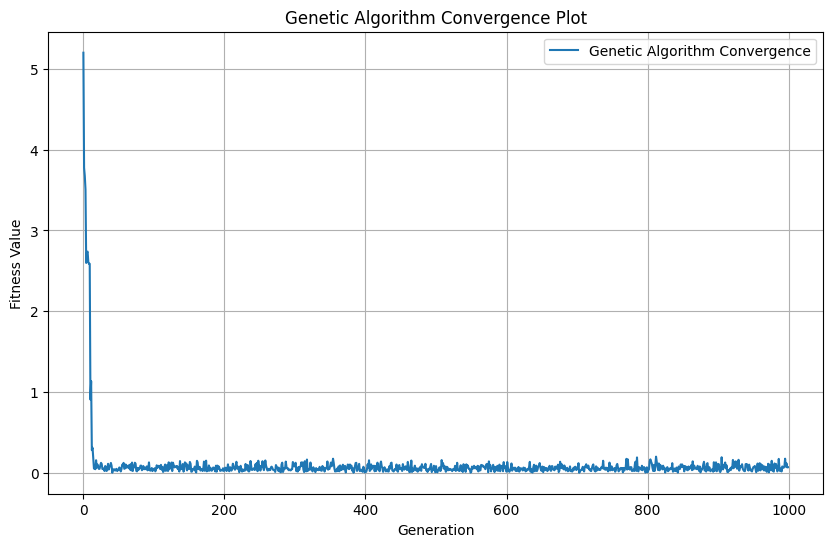

Differential Evolution Results for Ackley:
Optimal Solution: [1.91155958e-16 2.87074211e-16]
Fitness Value: 4.440892098500626e-16



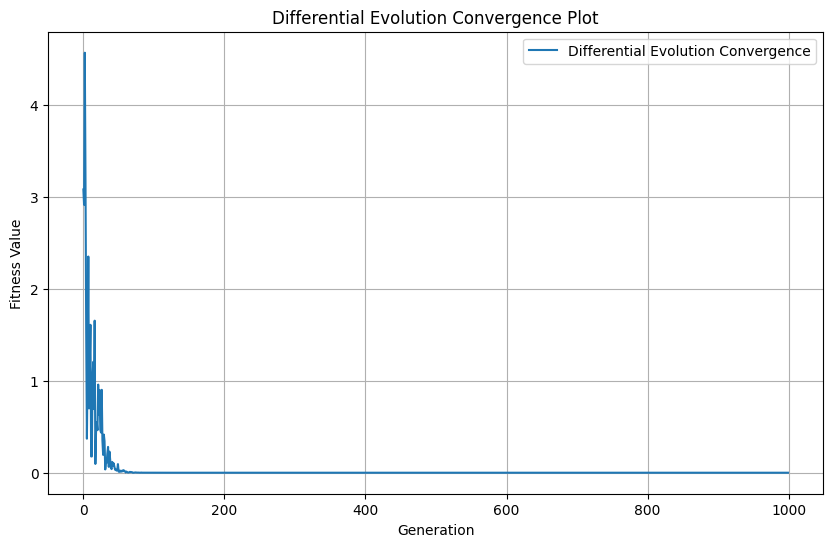

Running experiments for Bukin6 function:

Genetic Algorithm Results for Bukin6:
Optimal Solution: [-2.22008248  0.06508285]
Fitness Value: 2.814369217834182



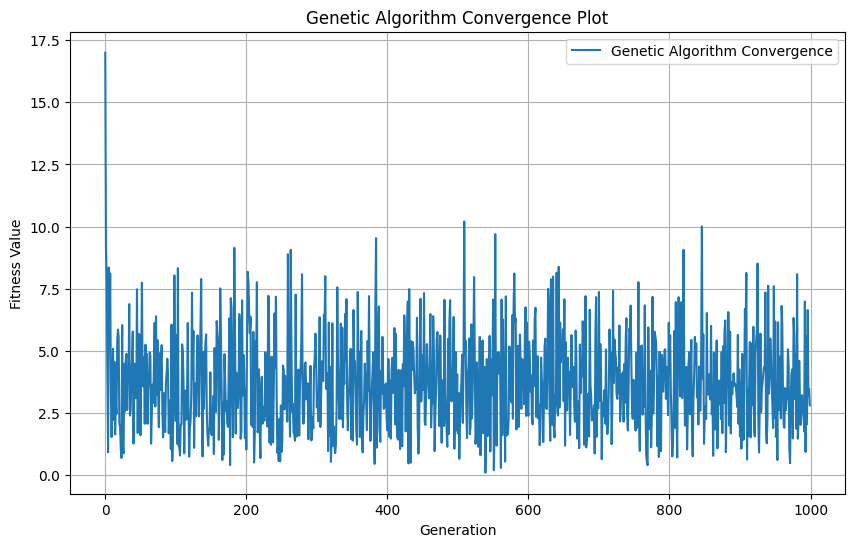

Differential Evolution Results for Bukin6:
Optimal Solution: [4.72147936 0.22292367]
Fitness Value: 0.1472147936259152



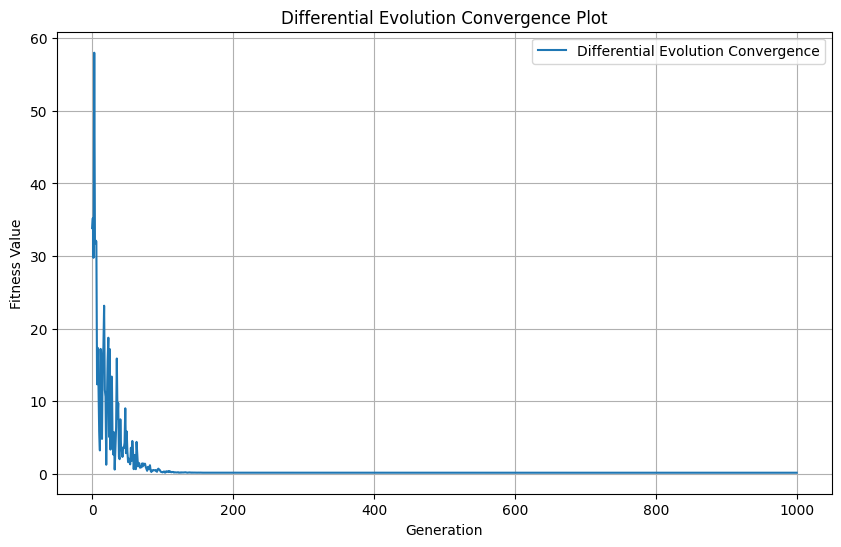

Running experiments for Cross-in-Tray function:

Genetic Algorithm Results for Cross-in-Tray:
Optimal Solution: [1.44803838 1.21880005]
Fitness Value: -2.06259462224193



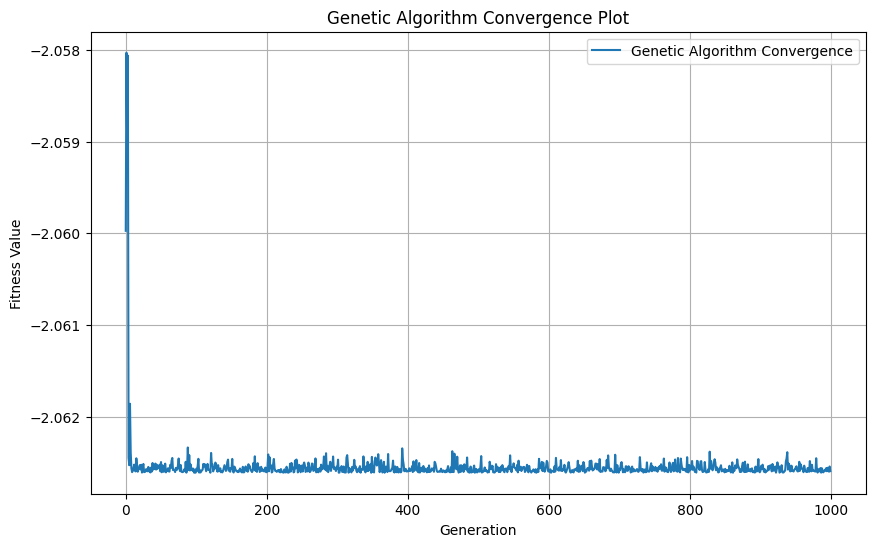

Differential Evolution Results for Cross-in-Tray:
Optimal Solution: [ 1.34940664 -1.34940662]
Fitness Value: -2.0626118708227397



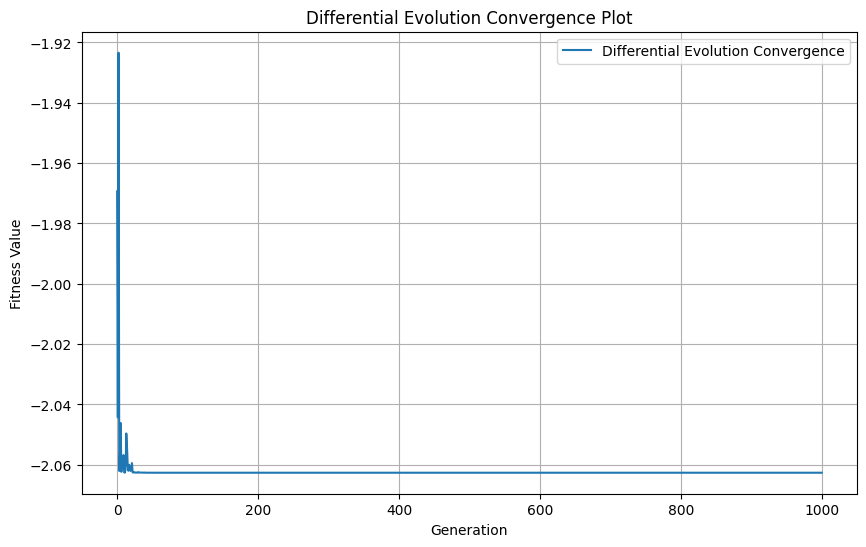

Running experiments for Drop-Wave function:

Genetic Algorithm Results for Drop-Wave:
Optimal Solution: [0.91514748 0.36323752]
Fitness Value: -0.9353268110836506



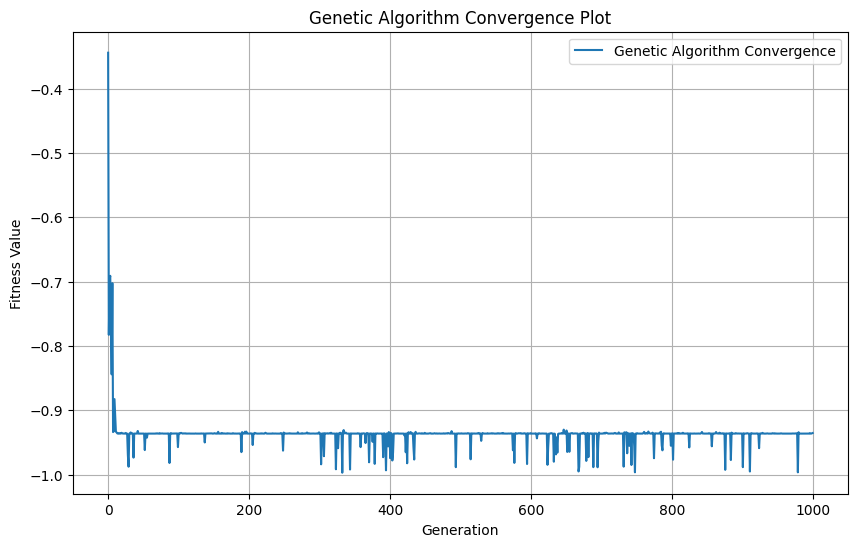

Differential Evolution Results for Drop-Wave:
Optimal Solution: [6.86711738e-10 1.30398650e-09]
Fitness Value: -1.0



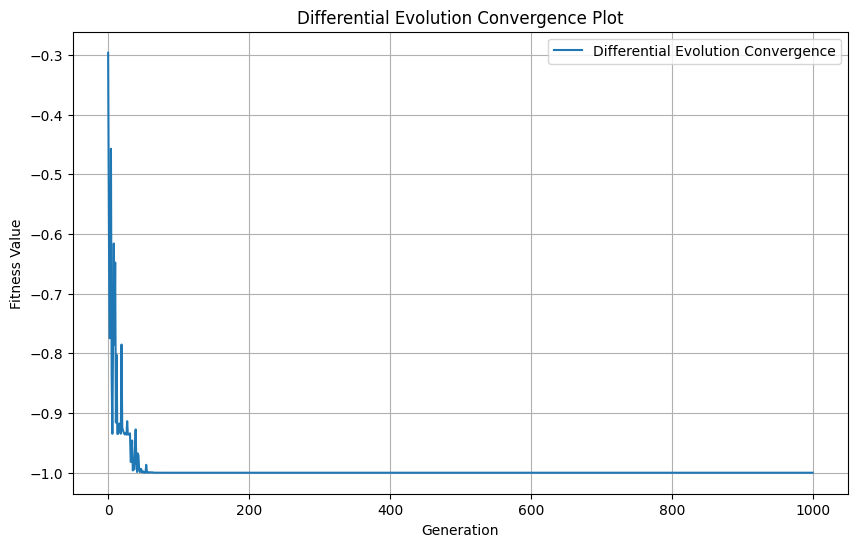

Running experiments for Egg-Holder function:

Genetic Algorithm Results for Egg-Holder:
Optimal Solution: [ 8.51483841 15.77873819]
Fitness Value: -66.84369561899672



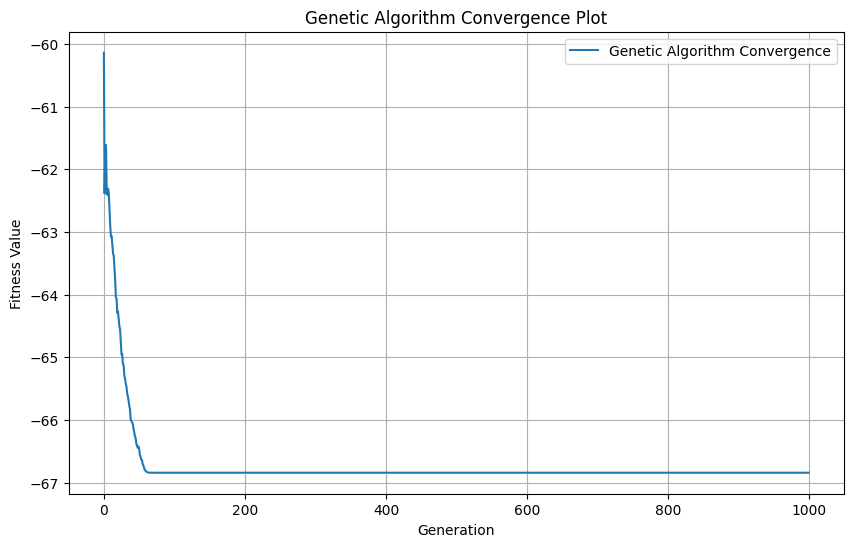

Differential Evolution Results for Egg-Holder:
Optimal Solution: [ 8.45693451 15.65091806]
Fitness Value: -66.84371732946403



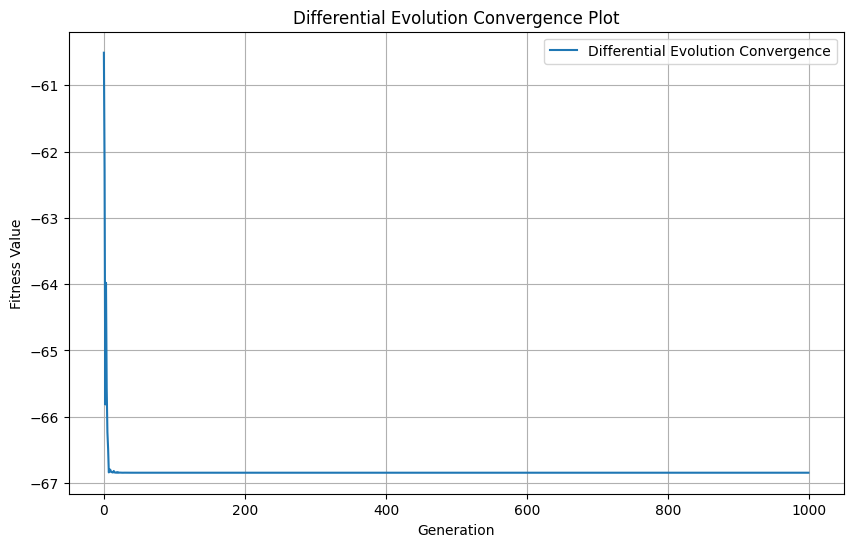

In [20]:
# Experiment loop
for function_name, objective_function in benchmark_functions.items():
    print(f"Running experiments for {function_name} function:\n")
    for algorithm_name, algorithm_class in algorithms.items():
        algorithm = algorithm_class(objective_function)
        best_solution, fitness, avg_fitness_history = algorithm.evolve(2)  # Assuming 2-dimensional optimization
        print_results(algorithm_name, function_name, best_solution, fitness)
        plot_convergence(algorithm_name, algorithm.fitness_history)

In [21]:
# Experiment loop
for function_name, objective_function in benchmark_functions.items():
    print(f"Running experiments for {function_name} function:\n")
    avg_fitnesses = {}  # Dictionary to store average fitness values for each algorithm

    for algorithm_name, algorithm_class in algorithms.items():
        algorithm = algorithm_class(objective_function)
        _, _, avg_fitness_history = algorithm.evolve(2)  # Assuming 2-dimensional optimization
        avg_fitnesses[algorithm_name] = avg_fitness_history

    # Print average fitness values across the number of generations separately for each algorithm
    print(f"Average Fitness Values across Generations for {function_name} function:")
    for algorithm_name, avg_fitness_history in avg_fitnesses.items():
        print(f"{algorithm_name}:")
        for gen, avg_fitness in enumerate(avg_fitness_history):
            print(f"  Generation {gen + 1}: {avg_fitness}")
    
    print("\n")  # Add a newline for clarity between different benchmark functions


Running experiments for Ackley function:

Average Fitness Values across Generations for Ackley function:
Genetic Algorithm:
  Generation 1: 14.307327334611875
  Generation 2: 12.44020366741931
  Generation 3: 10.414613760661334
  Generation 4: 8.848920470464135
  Generation 5: 6.850258106667619
  Generation 6: 5.086013121342604
  Generation 7: 4.142251703492063
  Generation 8: 3.300225608449645
  Generation 9: 2.782318975700654
  Generation 10: 2.316443931845009
  Generation 11: 1.7558212567384113
  Generation 12: 1.5650117269511759
  Generation 13: 1.444491279032025
  Generation 14: 1.472261772543773
  Generation 15: 1.3051241971515821
  Generation 16: 1.2698956496051272
  Generation 17: 1.2861464981056805
  Generation 18: 1.137476892305886
  Generation 19: 1.1492141380164533
  Generation 20: 1.0755526527238632
  Generation 21: 1.214819715331947
  Generation 22: 1.1100560740500456
  Generation 23: 1.1839886023789419
  Generation 24: 1.2810990311742407
  Generation 25: 1.22913983546443

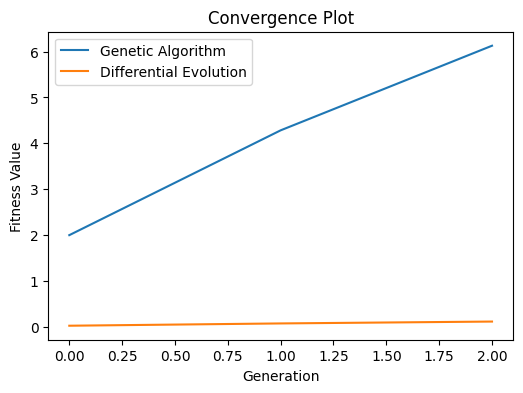

In [10]:
class GA_DE_GUI(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Genetic Algorithm vs Differential Evolution")
        self.geometry("800x600")

        self.selected_function = tk.StringVar()
        self.selected_function.set("Ackley")  # Default selected function

        self.ga_results = []
        self.de_results = []

        self.create_widgets()

    def create_widgets(self):
        # Function selection dropdown
        function_label = ttk.Label(self, text="Select Benchmark Function:")
        function_label.pack()
        function_combobox = ttk.Combobox(self, textvariable=self.selected_function,
                                          values=tuple(benchmark_functions.keys()))
        function_combobox.pack()

        # Button to run algorithms
        run_button = ttk.Button(self, text="Run Algorithms", command=self.run_algorithms)
        run_button.pack()

        # Listbox to display results
        self.result_listbox = tk.Listbox(self, width=100)
        self.result_listbox.pack()

        # Button to compare results
        compare_button = ttk.Button(self, text="Compare Results", command=self.compare_results)
        compare_button.pack()

        # Matplotlib Figure for convergence plots
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self)
        self.canvas.get_tk_widget().pack()

    def run_algorithms(self):
        function_name = self.selected_function.get()
        objective_function = benchmark_functions[function_name]

        # Run Genetic Algorithm
        ga_algorithm = GeneticAlgorithm(objective_function)
        ga_best_solutions = []
        for _ in range(30):
            best_solution, fitness = ga_algorithm.evolve(2)
            ga_best_solutions.append((best_solution, fitness))
        self.ga_results.append(ga_best_solutions)

        # Run Differential Evolution
        de_algorithm = DifferentialEvolution(objective_function)
        de_best_solutions = []
        for _ in range(30):
            best_solution, fitness = de_algorithm.evolve(2)
            de_best_solutions.append((best_solution, fitness))
        self.de_results.append(de_best_solutions)

        # Display results in the listbox
        self.display_results()

        # Plot convergence for Genetic Algorithm
        self.ax.clear()
        self.ax.plot([fitness for _, fitness in ga_best_solutions], label="Genetic Algorithm")
        self.ax.plot([fitness for _, fitness in de_best_solutions], label="Differential Evolution")
        self.ax.set_xlabel("Generation")
        self.ax.set_ylabel("Fitness Value")
        self.ax.set_title("Convergence Plot")
        self.ax.legend()
        self.canvas.draw()

    def display_results(self):
        self.result_listbox.delete(0, tk.END)
        for i, (ga_solution, de_solution) in enumerate(zip(self.ga_results[-1], self.de_results[-1])):
            self.result_listbox.insert(tk.END, f"Generation {i+1}: GA - {ga_solution[1]}, DE - {de_solution[1]}")

    def compare_results(self):
        if len(self.ga_results) < 2 or len(self.de_results) < 2:
            return  # Not enough previous results to compare

        # Retrieve previous results
        prev_ga_results = self.ga_results[-2]
        prev_de_results = self.de_results[-2]
        current_ga_results = self.ga_results[-1]
        current_de_results = self.de_results[-1]

        # Compare current results with previous results
        ga_improvement = sum(prev_fitness - curr_fitness for (_, prev_fitness), (_, curr_fitness) in zip(prev_ga_results, current_ga_results))
        de_improvement = sum(prev_fitness - curr_fitness for (_, prev_fitness), (_, curr_fitness) in zip(prev_de_results, current_de_results))

        # Display comparison
        tk.messagebox.showinfo("Comparison", f"GA improvement: {ga_improvement}\nDE improvement: {de_improvement}")

if __name__ == "__main__":
    app = GA_DE_GUI()
    app.mainloop()